In [1]:
import torch
import os
import numpy as np
import pickle
from torch.utils import data

In [2]:
x = torch.rand(5,3)

print(x)

tensor([[0.0942, 0.7034, 0.5380],
        [0.1556, 0.9638, 0.5203],
        [0.7533, 0.7386, 0.9327],
        [0.1576, 0.5183, 0.7306],
        [0.1377, 0.7514, 0.5503]])


In [3]:
class AudioFolder(data.Dataset):
    def __init__(self, root, subset, tr_val='train', split=0):
        self.trval = tr_val
        self.root = root
        fn = '../../data/splits/split-%d/%s_%s_dict.pickle' % (split, subset, tr_val)
        self.get_dictionary(fn)

    def __getitem__(self, index):
        fn = os.path.join(self.root, 'npy', self.dictionary[index]['path'][:-3]+'npy')
        audio = np.array(np.load(fn))
        tags = self.dictionary[index]['tags']
        return audio.astype('float32'), tags.astype('float32'), self.dictionary[index]['path']

    def get_dictionary(self, fn):
        with open(fn, 'rb') as pf:
            dictionary = pickle.load(pf)
        self.dictionary = dictionary

    def __len__(self):
        return len(self.dictionary)


def get_audio_loader(root, subset, batch_size, tr_val='train', split=0, num_workers=0):
    data_loader = data.DataLoader(dataset=AudioFolder(root, subset, tr_val, split),
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers)
    return data_loader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns 
import numpy.typing

from glob import glob

import librosa
import librosa.display

import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
audio_files = glob(r'C:\Users\User\Desktop\Computational Data Science\CDS Project\Extracted Data\00\*.mp3')

In [22]:
ipd.Audio(audio_files[0])

In [23]:
y, sample_rate = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sample rate: {sample_rate}')

y: [-1.9645086e-10  1.5279511e-10 -2.3283064e-10  4.3655746e-11
 -2.6193447e-10 -1.7462298e-10  3.4924597e-10  2.9103830e-10
  7.4214768e-10  7.5669959e-10]
shape y: (2066112,)
sample rate: 22050


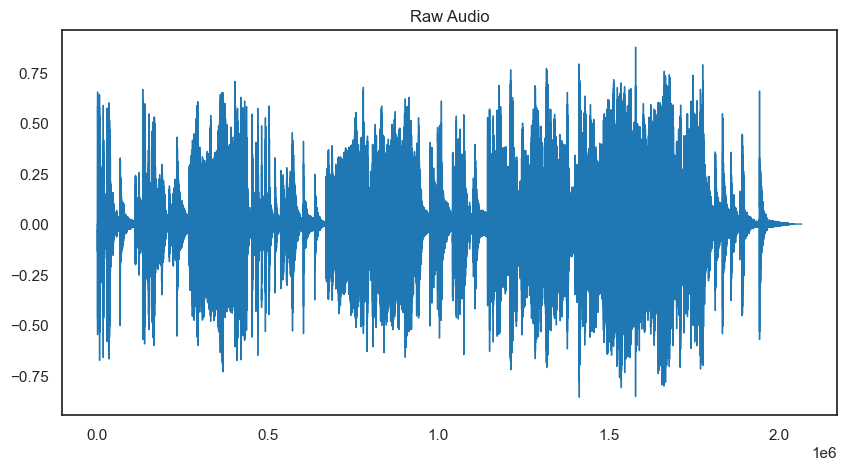

In [14]:
pd.Series(y).plot(figsize=(10,5), lw=1,title="Raw Audio")

plt.show()

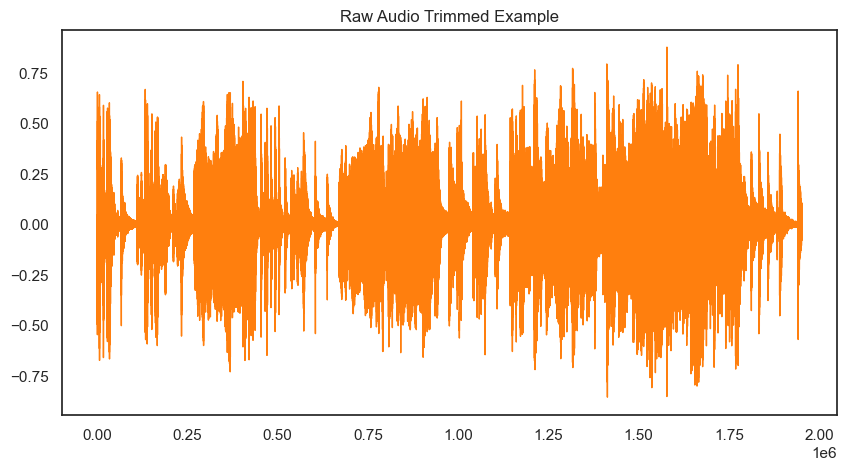

In [15]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

In [37]:
def load_audio(file_paths, sr=22050):
    """
    Load audio files using librosa.
    
    Args:
    - file_paths (list): List of file paths to the audio files.
    - sr (int): Sampling rate to load the audio (default: 22050).
    
    Returns:
    - audio_data_list (list): List of loaded audio data.
    - sr (int): Sampling rate of the loaded audio data.
    """
    audio_data_list = []
    for file_path in file_paths:
        # Load audio file
        audio_data, sr = librosa.load(file_path, sr=sr)
        audio_data_list.append(audio_data)
        
    
    return audio_data_list





In [6]:
import os
import librosa
import numpy as np

def get_mel_spectrograms(audio_paths, max_length=None):
    """
    Calculate mel spectrograms for multiple audio files and pad/truncate them to have the same shape.
    
    Args:
    - audio_paths (list): List of file paths to the audio files.
    - max_length (int): Maximum length to which all spectrograms will be padded/truncated. If None, use the maximum length among all spectrograms.
    
    Returns:
    - mel_spectrograms (numpy.ndarray): Array containing mel spectrograms with consistent shapes (num_samples, n_mels, max_length).
    - sample_rates (dict): Dictionary containing sample rates corresponding to each audio file, with track names as keys.
    """
    mel_spectrograms = []
    sample_rates_dict = {}
    
    # Calculate the maximum length among all spectrograms if max_length is None
    if max_length is None:
        max_length = 0
        for audio_path in audio_paths:
            y, sr = librosa.load(audio_path)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            max_length = max(max_length, S.shape[1])
    
    for audio_path in audio_paths:
        # Load audio file
        track_name = os.path.basename(audio_path)
        y, sr = librosa.load(audio_path)
        
        # Calculate Mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        
        # Convert to decibels (log scale)
        S_dB = librosa.power_to_db(S, ref=np.max)
        
        # Pad or truncate the spectrogram to have the same shape
        if S_dB.shape[1] > max_length:
            # Truncate if the spectrogram is longer than max_length
            S_dB = S_dB[:, :max_length]
        elif S_dB.shape[1] < max_length:
            # Pad if the spectrogram is shorter than max_length
            pad_width = max_length - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')
        
        # Save mel spectrogram and sample rate to dictionary
        mel_spectrograms.append(S_dB)
        sample_rates_dict[track_name] = sr
    
    return np.array(mel_spectrograms), sample_rates_dict

# Example usage
# audio_files = ["path_to_audio_file1.wav", "path_to_audio_file2.wav", "path_to_audio_file3.wav"]
mel_spectrograms, sample_rates_dict = get_mel_spectrograms(audio_files)
count = 0
# Access individual mel spectrograms and their corresponding sample rates
for track_name, mel_spec in zip(audio_files, mel_spectrograms):
    sr = sample_rates_dict[os.path.basename(track_name)]
    count += 1

print(f"Number of arrays: {count}")


Number of arrays: 202


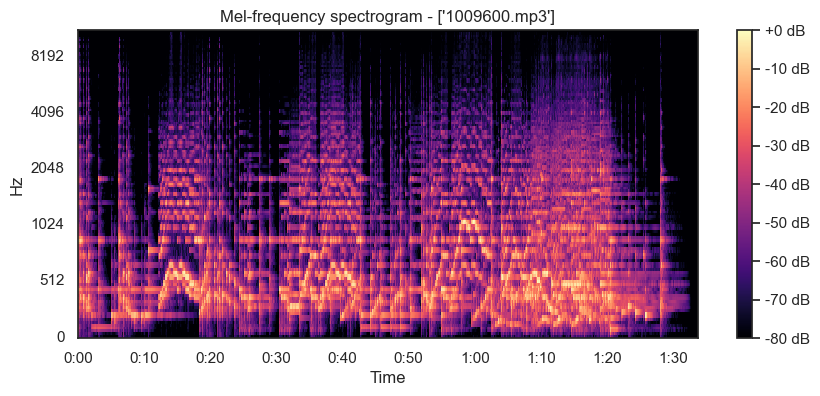

In [65]:
def plot_mel_spectrograms(mel_spectrograms, sample_rates, track_ls):
    """
    Plot mel spectrograms for multiple tracks from a dictionary.
    
    Args:
    - mel_spectrograms_dict (dict): Dictionary containing mel spectrograms (numpy.ndarray) with track names as keys.
    - sample_rates_dict (dict): Dictionary containing sample rates corresponding to each track, with track names as keys.
    - track_names (list): List of track names for which to plot the mel spectrograms.
    """
    
    for track_name in track_ls:
        mel_spec = mel_spectrograms[track_name]
        sr = sample_rates[track_name]

        # Plot Mel spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-frequency spectrogram - {track_ls}')
        plt.show()

# Example usage
# track_names is a list of track names for which you want to plot the mel spectrograms
track_all = list(mel_spectrograms_dict.keys())
track_names = []
track_names.append(track_all[0])
plot_mel_spectrograms(mel_spectrograms_dict, sample_rates_dict, track_names) #track_all for plotting all


In [64]:
print(track_names)

['1009600.mp3', '1012000.mp3', '1014400.mp3', '1028900.mp3', '1032700.mp3', '1037900.mp3', '1041500.mp3', '1042000.mp3', '1048300.mp3', '1052800.mp3', '1056400.mp3', '1062500.mp3', '1062600.mp3', '1066200.mp3', '1066500.mp3', '1069400.mp3', '1073700.mp3', '1076600.mp3', '1079400.mp3', '1080900.mp3', '1081000.mp3', '1082100.mp3', '1084200.mp3', '1086300.mp3', '1087100.mp3', '1088000.mp3', '1089300.mp3', '1090700.mp3', '1096800.mp3', '1101300.mp3', '1102300.mp3', '1103000.mp3', '1103300.mp3', '1105300.mp3', '1109900.mp3', '1110000.mp3', '1110500.mp3', '1112000.mp3', '1115700.mp3', '1116400.mp3', '1121400.mp3', '1125100.mp3', '1125400.mp3', '1129800.mp3', '1132200.mp3', '114200.mp3', '1155000.mp3', '1155900.mp3', '1158200.mp3', '1160600.mp3', '1162600.mp3', '1162700.mp3', '1163000.mp3', '1164200.mp3', '116600.mp3', '1166100.mp3', '1167300.mp3', '1168500.mp3', '1170400.mp3', '1170600.mp3', '1173500.mp3', '117800.mp3', '1178100.mp3', '1189900.mp3', '1195900.mp3', '1202100.mp3', '12100.mp3',

In [49]:
import torch.nn as nn
from torchsummary import summary





In [47]:
class CNN(nn.Module):
    def __init__(self, num_class=15):
        super(CNN, self).__init__()

        # init bn
        self.bn_init = nn.BatchNorm2d(1)

        # layer 1
        self.conv_1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.mp_1 = nn.MaxPool2d((2, 4))

        # layer 2
        self.conv_2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.mp_2 = nn.MaxPool2d((2, 4))

        # layer 3
        self.conv_3 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_3 = nn.BatchNorm2d(128)
        self.mp_3 = nn.MaxPool2d((2, 4))

        # layer 4
        self.conv_4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_4 = nn.BatchNorm2d(128)
        self.mp_4 = nn.MaxPool2d((3, 5))

        # layer 5
        self.conv_5 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn_5 = nn.BatchNorm2d(64)
        self.mp_5 = nn.MaxPool2d((4, 4))

        # classifier
        self.dense = nn.Linear(64, num_class)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)

        # init bn
        x = self.bn_init(x)

        # layer 1
        x = self.mp_1(nn.ELU()(self.bn_1(self.conv_1(x))))

        # layer 2
        x = self.mp_2(nn.ELU()(self.bn_2(self.conv_2(x))))

        # layer 3
        x = self.mp_3(nn.ELU()(self.bn_3(self.conv_3(x))))

        # layer 4
        x = self.mp_4(nn.ELU()(self.bn_4(self.conv_4(x))))

        # layer 5
        x = self.mp_5(nn.ELU()(self.bn_5(self.conv_5(x))))

        # classifier
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logit = nn.Sigmoid()(self.dense(x))

        return logit

In [ ]:
import pandas as pd

# Define the file path
file_path = r"C:\Users\User\Desktop\Computational Data Science\CDS Project\mtg-jamendo-dataset\data\autotagging_moodtheme.tsv"

# Initialize an empty list to store the data
data = []

# Open the file and read each line
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        # Split the line by tab separator
        fields = line.strip().split('\t')
        # Append the fields to the data list
        data.append(fields)

# Convert the list of lists into a DataFrame
df = pd.DataFrame(data)

#Column names
column_names = ['TRACK_ID', 'ARTIST_ID', 'ALBUM_ID', 'PATH', 'DURATION', 'TAGS_1','TAGS_2','TAGS_3','TAGS_4','TAGS_5','TAGS_6','TAGS_7','TAGS_8']
df.columns = column_names

# Display the first few rows of the DataFrame
df.tail()


TRACK_ID      ARTIST_ID      ALBUM_ID         PATH  DURATION  \
0       TRACK_ID      ARTIST_ID      ALBUM_ID         PATH  DURATION   
1  track_0000948  artist_000087  album_000149   48/948.mp3     212.7   
2  track_0000950  artist_000087  album_000149   50/950.mp3     248.0   
3  track_0000951  artist_000087  album_000149   51/951.mp3     199.7   
4  track_0002165  artist_000326  album_000347  65/2165.mp3     229.0   

                    TAGS_1 TAGS_2 TAGS_3 TAGS_4 TAGS_5 TAGS_6 TAGS_7 TAGS_8  
0                     TAGS   None   None   None   None   None   None   None  
1  mood/theme---background   None   None   None   None   None   None   None  
2  mood/theme---background   None   None   None   None   None   None   None  
3  mood/theme---background   None   None   None   None   None   None   None  
4        mood/theme---film   None   None   None   None   None   None   None

In [7]:
import commons

In [8]:
# Assuming you're in mtg-jamendo-dataset
input_file = r"C:\Users\User\Desktop\Computational Data Science\CDS Project\mtg-jamendo-dataset\data\autotagging_moodtheme.tsv"
tracks, tags, extra = commons.read_file(input_file)

tracks

Reading: 18486 tracks, 4506 albums, 1533 artists


{948: {'artist_id': 87,
  'album_id': 149,
  'path': '48/948.mp3',
  'duration': 212.7,
  'tags': ['mood/theme---background'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'background'}},
 950: {'artist_id': 87,
  'album_id': 149,
  'path': '50/950.mp3',
  'duration': 248.0,
  'tags': ['mood/theme---background'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'background'}},
 951: {'artist_id': 87,
  'album_id': 149,
  'path': '51/951.mp3',
  'duration': 199.7,
  'tags': ['mood/theme---background'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'background'}},
 2165: {'artist_id': 326,
  'album_id': 347,
  'path': '65/2165.mp3',
  'duration': 229.0,
  'tags': ['mood/theme---film'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'film'}},
 2263: {'artist_id': 320,
  'album_id': 366,
  'path': '63/2263.mp3',
  'duration': 494.7,
  'tags': ['mood/theme---melancholic'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'melancholic'}},

In [ ]:
import os
import librosa
import numpy as np

audio_folder = './audio_data'

def get_features_and_labels(data, max_len = None):
    features = []
    labels = []
    max_len = 0
    # audio_files = ['00/', '01/', '02/']

    for track_id, track_data in data.items():
        if track_data['path'].startswith('00/'):
            # if (tag in track_data['mood/theme'] for tag in ['energetic', 'relaxing', 'emotional', 'dark', 'love', 'sad']):
            if all(tag in ['energetic', 'relaxing', 'emotional', 'dark', 'love', 'sad'] for tag in track_data['mood/theme']):
                try:
                    # Load the audio file
                    filename = track_data['path']
                    updated_filename = filename.rsplit('.mp3', 1)[0] + '.low.mp3'
                    filepath = os.path.join(audio_folder, updated_filename)
                    y, sr = librosa.load(filepath, sr = 10000)

                    # Extract MFCCs
                    mfccs = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 30)
                    # print(f"The max length now is {max_len}; the mfccs.shape is {mfccs.shape}")

                    # Update max_len if necessary
                    max_len = max(max_len, mfccs.shape[1])

                    # Append MFCCs and track_id to lists
                    # features.append(mfccs.T)  # Transpose MFCCs array
                    features.append(mfccs)
                    labels.append(track_data['mood/theme'])
                except Exception as e:
                    print(f"Error processing track {track_id}: {e}")

    # Pad or truncate MFCCs arrays to ensure they all have the same length
    padded_features = []
    for mfccs in features:
        padded_mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode = 'constant')
        padded_features.append(padded_mfccs)

    # Convert lists to numpy arrays
    features_array = np.array(padded_features)

    return features_array, labels

# Assuming 'tracks' is the dictionary containing track data
X, y = get_features_and_labels(tracks)
